Окие доки, время попробовать что-то смоделировать
# Моделирование <a class="anchor" id="моделирование"></a>

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

import matplotlib.pyplot as plt

import scikitplot as skplt
import seaborn as sns

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

from IPython.display import clear_output

In [2]:
# no warnings pls
import warnings

def warn(*args, **kwargs):
    pass

warnings.warn = warn

### Prep <a class="anchor" id="prep"></a>

In [3]:
pd.set_option('display.max_columns', 500)
plt.style.use('fivethirtyeight')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
random_state = 0

In [4]:
df = pd.read_csv('data/clean.csv')
df.head()

,A1,A2,A3,A5,A9,A10,A11,A19,A20,A21,A23,A24,A25,A26,A28,A29,A30,A31,A32,A33,A36,B5,B7,B8,B12,B13,B14,B15,B16,B17,B18,B21,B22,B27,B34,B35,B37,B38,B39,B40,B41,B43,B44,B45,B47,B48,B49,B50,B51,B52,B55,B56,B57,B60,B61,B62,B70,B81,анемия
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# Разбиение на валидационную и тренировочную выборки со стратификацией по искомому полю
# Для показания результатов это надо:
#   В валидационной и тренировочной выборке одинаковое соотношение 
#   классов "с анемией" и "без анемии"
# Для финальной модели это плохо:
#   Модель могла "не увидеть" некоторые примеры "с анемией"
#   про примеры "без анемии" я молчу, их очень много
df_train, df_test = train_test_split(df, test_size=0.10, stratify=df['анемия'], shuffle=True, random_state=random_state)

In [6]:
y_train = df_train.pop('анемия')
x_train = df_train.copy()

y_test = df_test.pop('анемия')
x_test = df_test.copy()

tt = df.copy()
y = tt.pop('анемия')
x = tt.copy()

In [7]:
def _prep_axis(fig, ax4) -> None:
    """ 
    A helper function
    Turns off 4th axis in a 2x2 plot
    """
    ax4.axis('off')
    for ax in fig.get_axes():
        ax.label_outer()
        ax.set(xlabel='Predictions', ylabel='Ground truth')


def _get_heatmap(ax, ground_truth, predictions, title) -> None:
    """
    A helper function
    Plots confusion matrix (F1 score) for y and y_pred on a given ax
    """
    mat_train = confusion_matrix(ground_truth, predictions)
    sns.heatmap(mat_train, ax=ax, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    if ax is not None:
        ax.set_title(title)


def show_f1(train_pred, whole_pred, test_pred) -> None:
    """
    Creates a 2x2 plot of confusion matrices (F1 score) for a given predictions    
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (7, 7))

    _get_heatmap(ax1, y_train, train_pred, 'Train set')
    _get_heatmap(ax2, y, whole_pred, 'Whole set')
    _get_heatmap(ax3, y_test, test_pred, 'Test set')

    _prep_axis(fig, ax4)

    plt.show()


def _get_roc(ax, ground_truth, pred_probabilities, title: str) -> None:
    """
    A helper function
    Plots ROC curve for y and y_pred_proba on a given ax
    """
    skplt.metrics.plot_roc_curve(
        ground_truth, pred_probabilities,
        ax=ax, title=title, text_fontsize='small')

def show_roc(train_pred, whole_pred, test_pred) -> None:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

    _get_roc(ax1, y_train, train_pred, 'Train set')
    _get_roc(ax2, y, whole_pred, 'Whole set')
    _get_roc(ax3, y_test, test_pred, 'Test set')

    _prep_axis(fig, ax4)
    plt.show()


def test_model(clf, name: str, visualize = True, roc = False) -> list[float]:
    """
    Prints accuracy for a given classificator on 3 subsets for a give classificator

    Visualizes results if visualize = True:
    
    If specified plots an F1 confusion matrix 
    If specified plots an ROC curve
    """
    train_set = round(clf.score(x_train, y_train) * 100, 2)
    test_set = round(clf.score(x_test, y_test) * 100, 2)
    whole_set = round(clf.score(x, y) * 100, 2)

    # Numeric output
    print('=========================================================')
    print(f'Tested {name} classifier')
    print(f'Success rate on train subset = {train_set}%')
    print(f'Success rate on test subset = {test_set}%')
    print(f'Success rate on whole dataset = {whole_set}%')
    print('=========================================================')
    
    train_pred = clf.predict(x_train)
    whole_pred = clf.predict(x)
    test_pred = clf.predict(x_test)

    if visualize:
        show_f1(
            train_pred,
            whole_pred,
            test_pred
            )
        # if roc:
        #     show_roc(
        #         train_pred,
        #         whole_pred, 
        #         test_pred
        #         )

    return test_pred, [train_set, test_set, whole_set]

Ура, сами модели  
После отдельных блоков есть общая табличка, можете игнорировать и бежать сразу туда

## Одиночная модель <a class="anchor" id="одиночная-модель"></a>

### 1. Random Forest

RF это конечно сама по себе ансамблевая модель, но мы это упустим...

Tested Random Forest classifier
Success rate on train subset = 98.98%
Success rate on test subset = 77.27%
Success rate on whole dataset = 96.78%


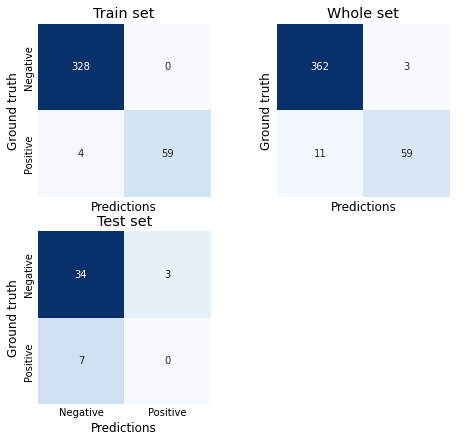

In [8]:
rfc = RandomForestClassifier(n_estimators=1000, 
                             random_state=0)
rfc.fit(x_train, y_train)
rfc_pred, random_forest_res = test_model(rfc, 'Random Forest')

### 2. Logistic Regression

Tested Logistic Regression classifier
Success rate on train subset = 83.89%
Success rate on test subset = 84.09%
Success rate on whole dataset = 83.91%


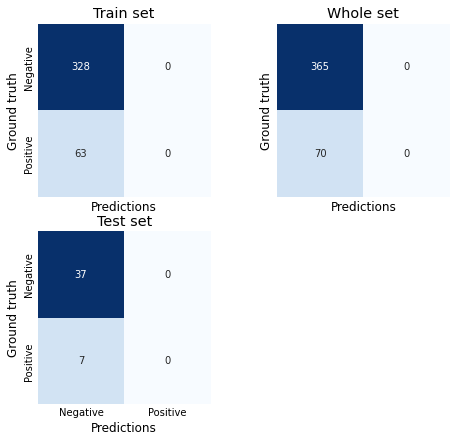

In [9]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred, logreg_res = test_model(logreg, 'Logistic Regression')

### 3. Support Vector Machines

Tested Support Vector Machines classifier
Success rate on train subset = 83.89%
Success rate on test subset = 84.09%
Success rate on whole dataset = 83.91%


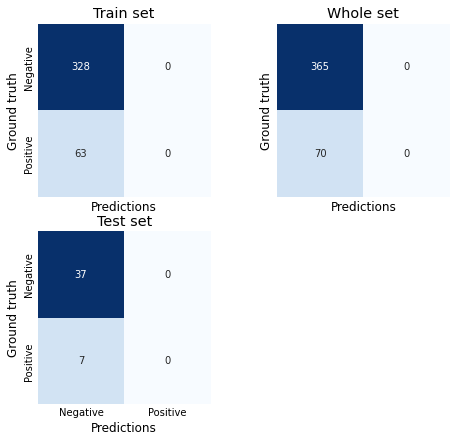

In [10]:
svc = SVC()
svc.fit(x_train, y_train)

svc_pred, svc_res = test_model(svc, 'Support Vector Machines')

### 4. k-Nearest Neighbors

Tested k-Nearest Neighbors classifier
Success rate on train subset = 86.7%
Success rate on test subset = 79.55%
Success rate on whole dataset = 85.98%


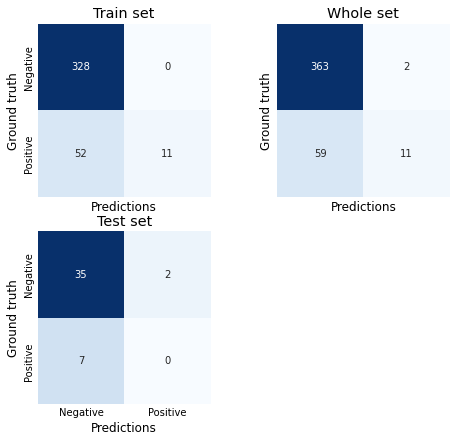

In [11]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train, y_train)

knn_pred, knn_res = test_model(knn, 'k-Nearest Neighbors')

### 5. Gaussian Naive Bayes

Tested Gaussian Naive Bayes classifier
Success rate on train subset = 31.2%
Success rate on test subset = 34.09%
Success rate on whole dataset = 31.49%


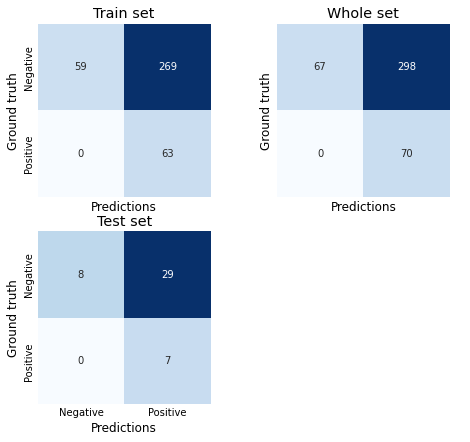

In [12]:
gaussian = GaussianNB()
gaussian.fit(x_train, y_train)

gaussian_pred, gaussian_res = test_model(gaussian, 'Gaussian Naive Bayes')

### 6. Perceptron

Tested Perceptron classifier
Success rate on train subset = 84.4%
Success rate on test subset = 84.09%
Success rate on whole dataset = 84.37%


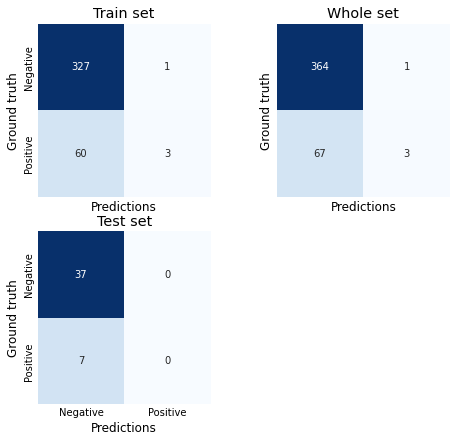

In [13]:
perceptron = Perceptron()
perceptron.fit(x_train, y_train)

perceptron_pred, perceptron_res = test_model(perceptron, 'Perceptron')

### 7. Linear SVC

Tested Linear SVC classifier
Success rate on train subset = 84.14%
Success rate on test subset = 84.09%
Success rate on whole dataset = 84.14%


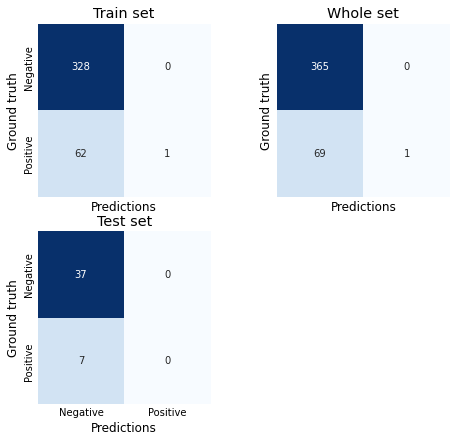

In [14]:
linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)

linear_svc_pred, linear_svc_res = test_model(linear_svc, 'Linear SVC')

### 8. Stochastic Gradient Descent

Tested Stochastic Gradient Descent classifier
Success rate on train subset = 84.14%
Success rate on test subset = 72.73%
Success rate on whole dataset = 82.99%


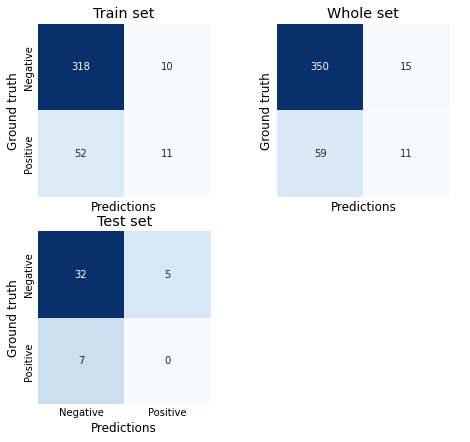

In [15]:
sgd = SGDClassifier()
sgd.fit(x_train, y_train)

sgd_pred, sgd_res = test_model(sgd, 'Stochastic Gradient Descent')

### Результаты одиночных моделей

In [16]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression',
              'Random Forest', 'Naive Bayes', 'Perceptron',
              'Stochastic Gradient Decent', 'Linear SVC'],
    'Test Score': [svc_res[1], knn_res[1], logreg_res[1],
                   random_forest_res[1], gaussian_res[1], perceptron_res[1],
                   sgd_res[1], linear_svc_res[1]],

    'Train Score': [svc_res[0], knn_res[0], logreg_res[0],
              random_forest_res[0], gaussian_res[0], perceptron_res[0],
              sgd_res[0], linear_svc_res[0]],
    'Whole set Score': [svc_res[2], knn_res[2], logreg_res[2],
                        random_forest_res[2], gaussian_res[2], perceptron_res[2],
                        sgd_res[2], linear_svc_res[2]]})
models.sort_values(by=['Test Score'], ascending=False)

# Пожалуйста, игнорируйте левые индексы и очередность разных оценок
# Здесь идет сортировка по тестовой выборке

,Model,Test Score,Train Score,Whole set Score
0,Support Vector Machines,84.09,83.89,83.91
2,Logistic Regression,84.09,83.89,83.91
5,Perceptron,84.09,84.40,84.37
7,Linear SVC,84.09,84.14,84.14
1,KNN,79.55,86.70,85.98
3,Random Forest,77.27,98.98,96.78
6,Stochastic Gradient Decent,72.73,84.14,82.99
4,Naive Bayes,34.09,31.20,31.49


In [17]:
models.sort_values(by=['Whole set Score'], ascending=False)

# А здесь сортировка по всему датасету

,Model,Test Score,Train Score,Whole set Score
3,Random Forest,77.27,98.98,96.78
1,KNN,79.55,86.70,85.98
5,Perceptron,84.09,84.40,84.37
7,Linear SVC,84.09,84.14,84.14
0,Support Vector Machines,84.09,83.89,83.91
2,Logistic Regression,84.09,83.89,83.91
6,Stochastic Gradient Decent,72.73,84.14,82.99
4,Naive Bayes,34.09,31.20,31.49


### 9. (Бонус) Neaural Net


In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from keras import regularizers
from tensorflow.keras.optimizers import Adamax


In [19]:
# перегон данных в формат, который понравится DNN
tf_x_train = tf.convert_to_tensor(x_train)
tf_y_train = tf.convert_to_tensor(y_train)
tf_y_train = tf.one_hot(tf_y_train, 2, on_value=0.0, off_value=1.0)

tf_x_test = tf.convert_to_tensor(x_test)
tf_y_test = tf.convert_to_tensor(y_test)
tf_y_test = tf.one_hot(tf_y_test, 2, on_value=0.0, off_value=1.0)


In [20]:
# сама модель, я пробовал много разных, делать модель шире и глубже смысла нет - результат одинаковый
model = Sequential()

model.add(Input(shape = (58,)))
model.add(Dense(32, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(128, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
#                 bias_regularizer=regularizers.l1(0.006), activation='relu'))
# model.add(Dense(512, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
#           bias_regularizer=regularizers.l1(0.006), activation='relu'))
# model.add(Dense(128, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
#           bias_regularizer=regularizers.l1(0.006), activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(Adamax(learning_rate = 0.01),
              loss=tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.1),
              metrics = ['Accuracy'])


In [21]:
model.fit(tf_x_train, tf_y_train,
    epochs = 1,
    batch_size = 16,
    validation_data = (tf_x_test, tf_y_test)
)

25/25 [==============================] - 1s 21ms/step - loss: 0.8678 - Accuracy: 0.7698 - val_loss: 0.6347 - val_Accuracy: 0.8409


In [22]:
preds = model.predict(tf_x_test)
res = []
for idx in range(len(preds)):
    res.append(np.argmax(y[idx]) == np.argmax(preds[idx]))
    # print(f'True idx = {np.argmax(true[idx])}')
    # print(f'Predicted idx = {np.argmax(preds[idx])}')
print(f'Accuracy: {np.sum(y) / np.sum(res)*100:.04}%')


2/2 [==============================] - 0s 4ms/step
Accuracy: inf%


C:\Users\3mpti\AppData\Local\Temp\ipykernel_2612\362923115.py:7: RuntimeWarning: divide by zero encountered in longlong_scalars
  print(f'Accuracy: {np.sum(y) / np.sum(res)*100:.04}%')


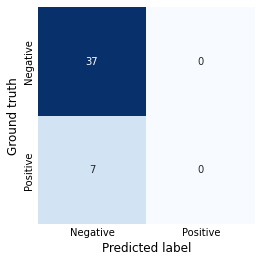

In [23]:
mat = confusion_matrix(y_test, res)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted label')
plt.ylabel('Ground truth')
plt.show()

In [24]:
# Тоже самое, что и confusion matrix, но немного в другом формате
preds = (preds > 0.5)
clr = classification_report(tf_y_test, preds, \
                            target_names=['True', 'False'], \
                            digits=4, \
                            zero_division = 0)
print(f"Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

        True     0.0000    0.0000    0.0000         7
       False     0.8409    1.0000    0.9136        37

   micro avg     0.8409    0.8409    0.8409        44
   macro avg     0.4205    0.5000    0.4568        44
weighted avg     0.7071    0.8409    0.7682        44
 samples avg     0.8409    0.8409    0.8409        44



### Небольшие выводы

Данные несбалансированны, это очень явно, соотношение 5:1 это оч жестко. Большинство моделей, а именно `Simple DNN`, `LogReg`, `SVM`, `Linear SVM`, `SGD` и `Perceptron` решили, что науличший результат они получат, если все данные припишут к более частому классу.  
`Gaussian Naive Bayes` выдает что-то непонятное.  
Остаются `Random Forest` и `KNN`. И если хороший результат первой модели я еще ожидал, то вторая удивила. Простую полносвязную нейронку я выбрасывать пока не буду, хотя вероятно смысла в ней не густо и результаты она будет выдавать на уровне RF. Вообще, возможно не стоит вообще ничего выбрать, а отбалансировать данные и попробовать все модели снова  

Попробую занятсья ансаблированием

## Ансамбли

Очень простая и интересная стратегия при работе с несбалансированными данными.  

Суть в том, что мы делим общий датасет на несколько поддатасетов, каждый из которых содержит полную копию наименьшего по вхождению класса и часть превосходящего по обьему классу  

Например в данном датасете соотношение 5/1, поэтому мы создаем 5 датасетов и учим 5 отдельных классификаторов на этих датасетах, а потом 'обьединяем' их результаты. В теории это должно помочь, но не обязательно.  

Вообще лучше всего ансмаблировать разные типы моделей, но здесь пока что ансамблируются модели одного типа, обученные на разных поддатасетах. Ансамблирвоанием разных типов моделей можно заняться позже. 

### Prep

In [25]:
from sklearn.utils import shuffle

In [26]:
df_train, df_test = train_test_split(
                                    df, test_size=0.20, 
                                    stratify=df['анемия'], 
                                    shuffle=True, 
                                    random_state=random_state
                                    )


In [27]:
len(df_train.loc[df['анемия'] == 0]) / len(df_train.loc[df['анемия'] == 1])

5.214285714285714

In [28]:
# Составляю сабсет только с позитивными случаями и сабсет только в негативными, последний дроблю на 5
df_positive = df_train.loc[df_train['анемия'] == 1].copy()
df_negative = np.array_split(df_train.loc[df_train['анемия'] == 0], 5)

In [29]:
def create_ensemble(clf_func, args):
    """
    Creates an {n} classifier ensemble of a given classifier function type with {args} as hyperparameters
    """
    classifiers = []
    for ndf in df_negative:
        clf = clf_func(**args)
        sub_df = pd.concat([df_positive, ndf])
        sub_df = shuffle(sub_df, random_state=random_state)
        y_sub = sub_df.pop('анемия')
        x_sub = sub_df.copy()
        clf.fit(x_sub, y_sub)
        classifiers.append(clf)
    return classifiers


def prediction_on_ensemble(x, y, ensemble, factor = 1.35, is_roc = False):
    """
    Runs prediciton on ensemble
    """
    preds = []
    for clf in ensemble:
        if is_roc:
            pred = clf.predict_proba(x)
        if not is_roc:
            pred = clf.predict(x)
        preds.append(pred*factor)

    # preds = sum(np.array(preds) / len(ensemble))
    preds = np.array(preds)
    preds = np.mean(preds, axis = 0)
    if is_roc:
        return preds

    res = []
    for idx in range(len(preds)):
        res.append(np.array(y)[idx] == round(preds[idx]))

    return res

def visualise_ensemble(ensemble, factor = 1.35, roc = True):
    """
    Visualized predictions on a given ensemble

    Plots an F1 score confusion matrix
    Plots a ROC curve if specified
    """
    show_f1(
        prediction_on_ensemble(x_train, y_train, ensemble, factor=factor),
        prediction_on_ensemble(x, y, ensemble, factor=factor),
        prediction_on_ensemble(x_test, y_test, ensemble, factor=factor)
        )

    if not roc:
        return

    show_roc(
        prediction_on_ensemble(x_train, y_train, ensemble, factor=factor, is_roc = True),
        prediction_on_ensemble(x, y, ensemble, factor=factor, is_roc=True),
        prediction_on_ensemble(x_test, y_test, ensemble, factor=factor, is_roc = True)
    )
    

### 1. Random Forest Ensemble

In [30]:
rf_ensemble = create_ensemble(RandomForestClassifier, {'n_estimators': 1000, 'random_state' : 0})

#### Пример каждого классификатора ансамбля по отдельности

Tested RF #1 classifier
Success rate on train subset = 58.57%
Success rate on test subset = 43.18%
Success rate on whole dataset = 57.01%


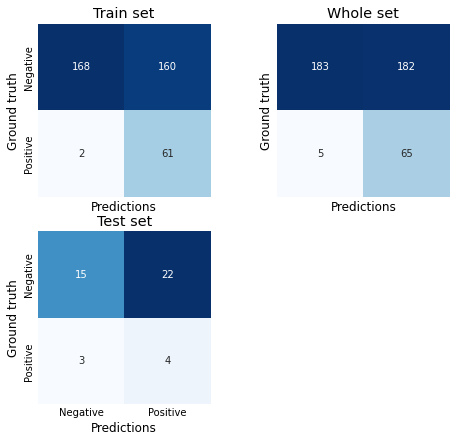

Tested RF #2 classifier
Success rate on train subset = 63.68%
Success rate on test subset = 40.91%
Success rate on whole dataset = 61.38%


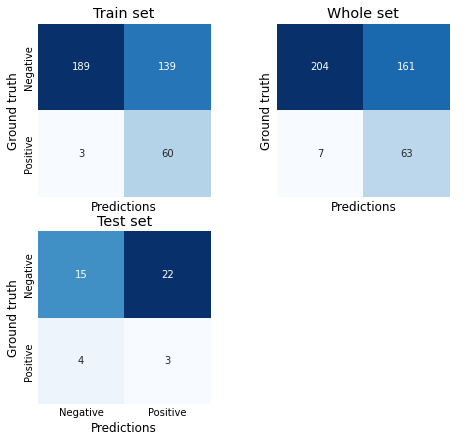

Tested RF #3 classifier
Success rate on train subset = 60.1%
Success rate on test subset = 50.0%
Success rate on whole dataset = 59.08%


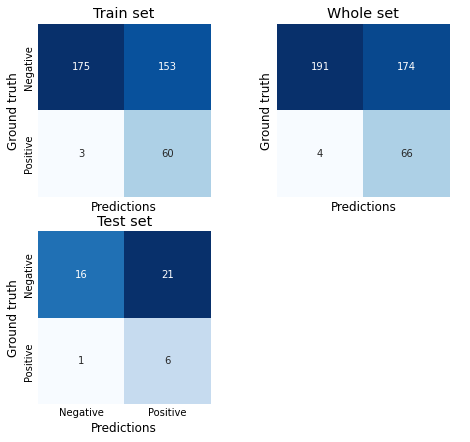

Tested RF #4 classifier
Success rate on train subset = 63.17%
Success rate on test subset = 43.18%
Success rate on whole dataset = 61.15%


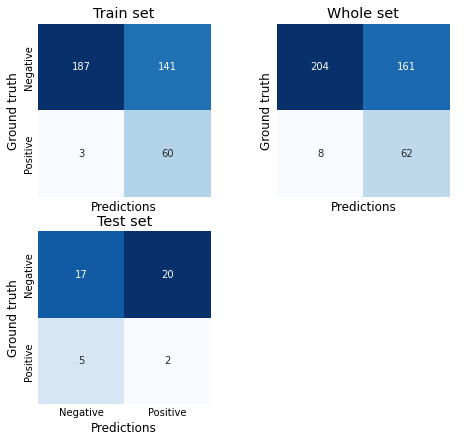

Tested RF #5 classifier
Success rate on train subset = 62.66%
Success rate on test subset = 45.45%
Success rate on whole dataset = 60.92%


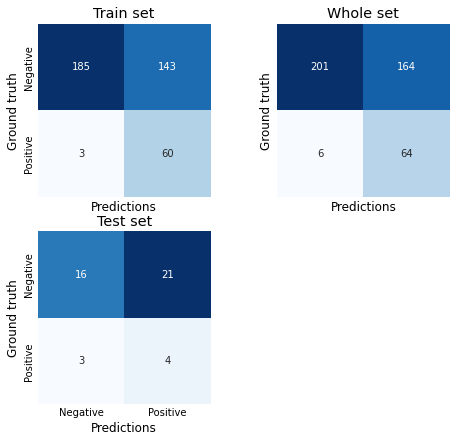

In [31]:
# покажу пример насколько каждый классификатор по отдельности говно
i = 1
for clf in rf_ensemble:
    test_model(clf, f'RF #{i}', roc = False)
    i+=1


Ну то есть каждый классификатор по отдельности говно  

Но если попробовать обьединить их результаты....

#### Ансмаль результаты

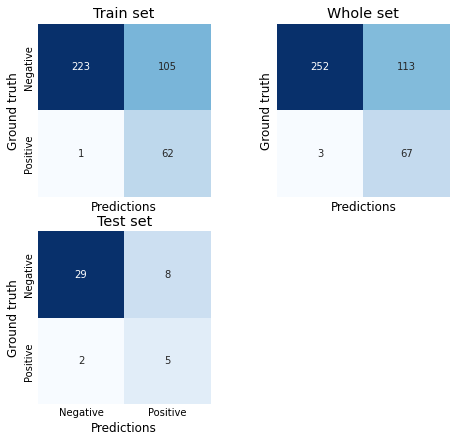

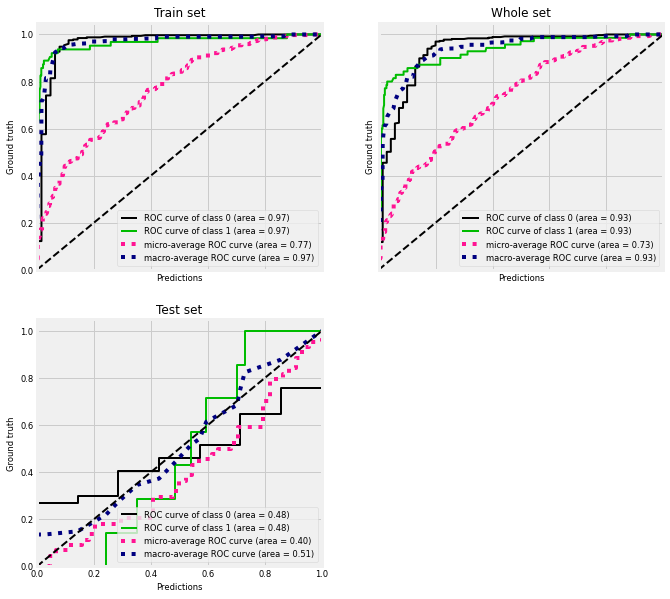

In [32]:
visualise_ensemble(rf_ensemble)

### 2. LogReg Ensemble

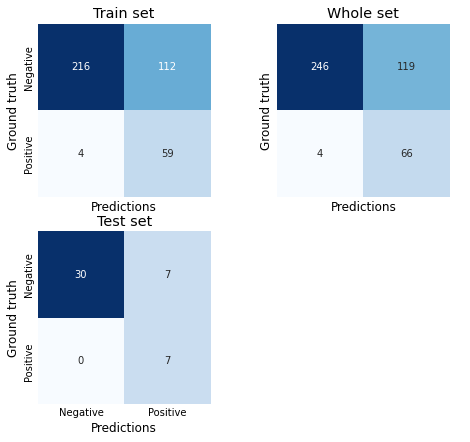

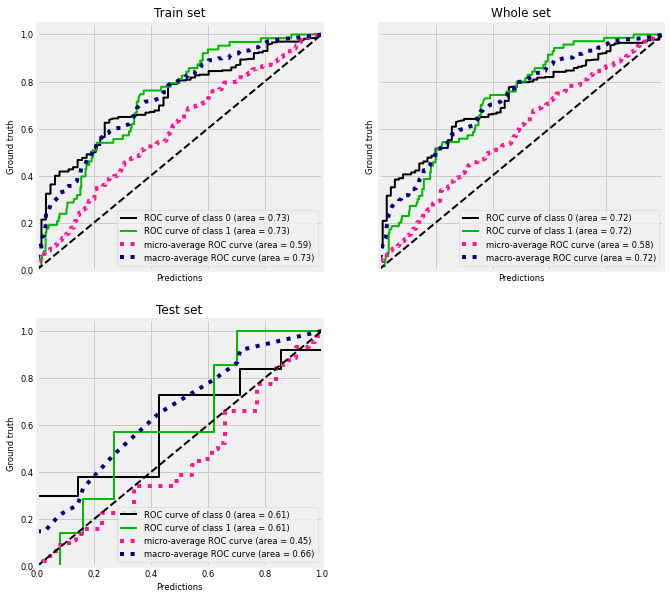

In [33]:
logreg_ensemble = create_ensemble(LogisticRegression, {})
visualise_ensemble(logreg_ensemble)

### 3. SVM Ensemble

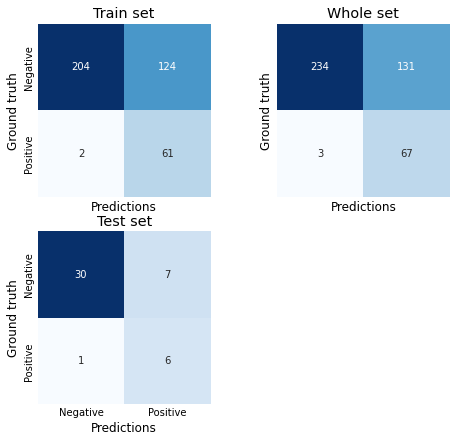

In [34]:
svm_ensemble = create_ensemble(SVC, {})
visualise_ensemble(svm_ensemble, roc = False)

### 4. KNN Ensemble

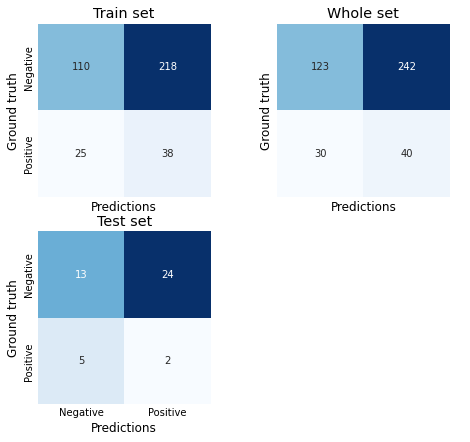

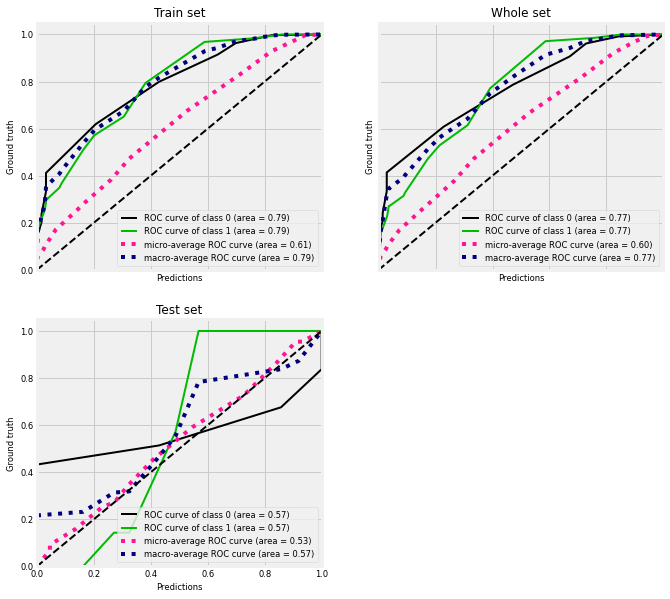

In [35]:
knn_ensemble = create_ensemble(KNeighborsClassifier, {'n_neighbors': 2})
visualise_ensemble(knn_ensemble)

### 5. GNB Ensebmle

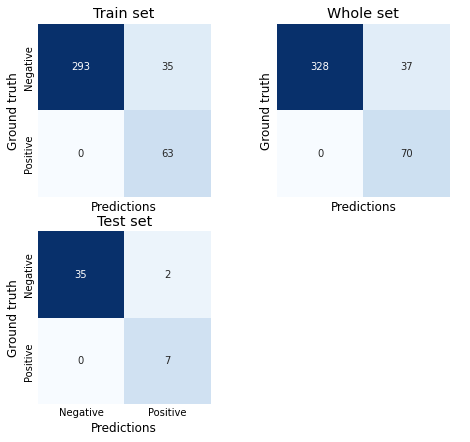

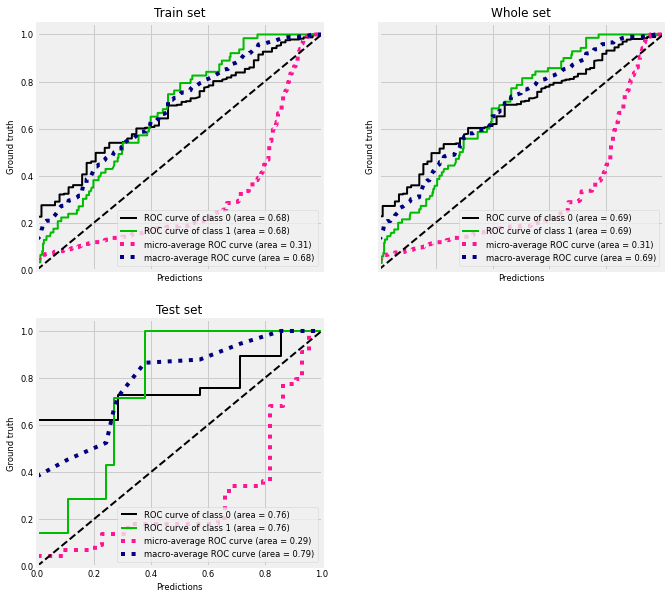

In [36]:
gnb_ensemble = create_ensemble(GaussianNB, {})
visualise_ensemble(gnb_ensemble, 1.35)    

### 6. Perceptron Ensemble

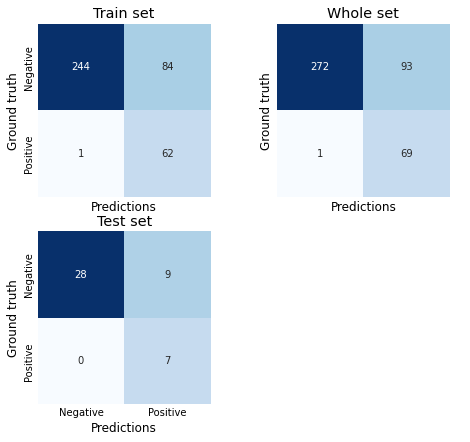

In [37]:
perceptron_ensemble = create_ensemble(Perceptron, {})
visualise_ensemble(perceptron_ensemble, roc = False)

### 7. Linear SVC Ensemble

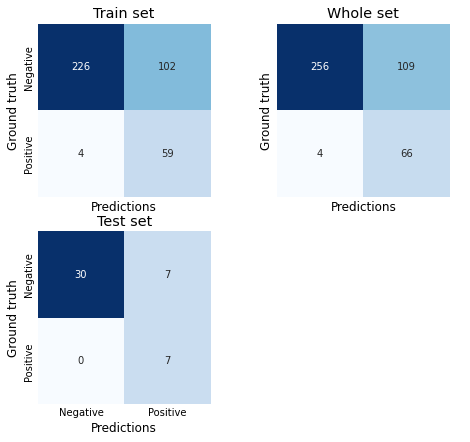

In [38]:
lsvc_ensemble = create_ensemble(LinearSVC, {})
visualise_ensemble(lsvc_ensemble, roc = False)

### 8. SGD Ensemble

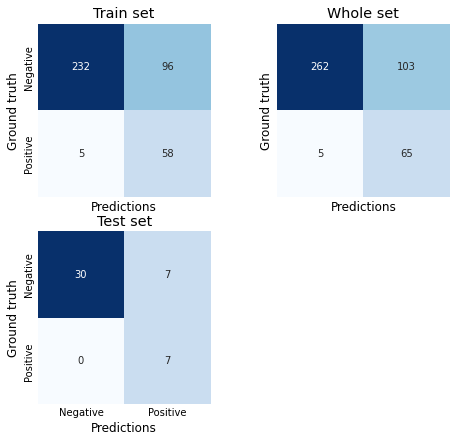

In [39]:
sgd_ensemble = create_ensemble(SGDClassifier, {})
visualise_ensemble(sgd_ensemble, roc = False)

### Вывод по ансамблям

Удивительно, но по ансамблям выходит совершенно другой вывод, я буду говорить в терминах положительный_диагноз-отрицательный_диагноз / 1-0, в основном ссылаясь на тестовый датасет, если не скзаано иначе:  

- `Random forest` и `SGD` хорошо указывают на положительные случаи, но очень сильно промахиваются по отрицательным
- `LogReg`, `Perceptron`, `Linear SVC` чуть ли не равнораспределенно по классам дают результаты
- у `SVM` и `KNN` картина тоже достаточно случайная
- `GNB` ***ОЧЕНЬ*** удивил

0 промахов по положительным диагнозам - на всех кто его имеют ДЕЙСТВИТЕЛЬНО указал алгоритм, как на тренировочной так и на тестовой выборках. 16% ошибка ошибка по отрицательным случаям на тестовой выборке и ~13% на всей выборке. Вау. ***Апплодирую стоя***. Главное чтобы я ничего не спутал.  

Теперь можно попробовать ансамблировать *ансмабль GNB* и что-либо еще. Но я пока не знаю как...


## Бонусные методы

### 9. Catboost

In [40]:
from catboost import CatBoostClassifier

In [41]:
catboost_ensemble = create_ensemble(CatBoostClassifier, {'iterations': 100, 'learning_rate' : 0.0001})

0:	learn: 0.6931446	total: 145ms	remaining: 14.3s
1:	learn: 0.6931321	total: 149ms	remaining: 7.31s
2:	learn: 0.6931210	total: 154ms	remaining: 4.96s
3:	learn: 0.6931052	total: 158ms	remaining: 3.78s
4:	learn: 0.6930853	total: 161ms	remaining: 3.06s
5:	learn: 0.6930668	total: 165ms	remaining: 2.59s
6:	learn: 0.6930526	total: 170ms	remaining: 2.25s
7:	learn: 0.6930427	total: 174ms	remaining: 2s
8:	learn: 0.6930289	total: 178ms	remaining: 1.8s
9:	learn: 0.6930055	total: 182ms	remaining: 1.64s
10:	learn: 0.6929974	total: 186ms	remaining: 1.5s
11:	learn: 0.6929860	total: 189ms	remaining: 1.39s
12:	learn: 0.6929718	total: 193ms	remaining: 1.29s
13:	learn: 0.6929493	total: 197ms	remaining: 1.21s
14:	learn: 0.6929349	total: 202ms	remaining: 1.14s
15:	learn: 0.6929183	total: 206ms	remaining: 1.08s
16:	learn: 0.6929012	total: 209ms	remaining: 1.02s
17:	learn: 0.6928904	total: 213ms	remaining: 970ms
18:	learn: 0.6928692	total: 217ms	remaining: 924ms
19:	learn: 0.6928630	total: 221ms	remaining: 8

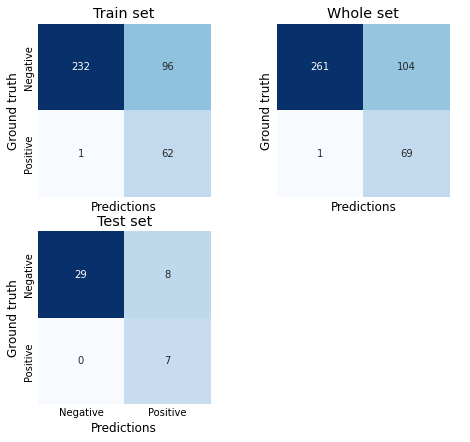

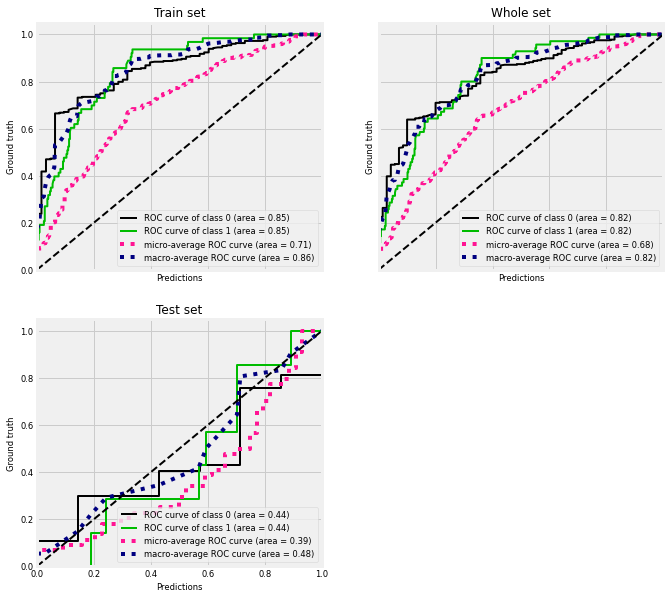

In [42]:
visualise_ensemble(catboost_ensemble, roc=True)

### 10. XGB

In [43]:
import xgboost as xgb

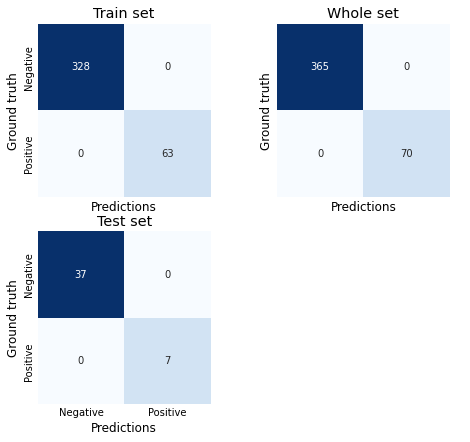

In [44]:
xgb_ensemble = create_ensemble(xgb.XGBRegressor, {'n_estimators' : 1000, 'learning_rate' :0.0001})
visualise_ensemble(xgb_ensemble, roc=False)

😳 😳😳😳 😳😳😳 😳😳😳 😳  
😳 ЭТО ЧЕ ЗА ПРИКОЛЫ ТАКИЕ 😳  
😳 😳😳😳 😳😳😳 😳😳😳 😳

### Вывод по бонусным методам

`XGBRegressor` на стероидах похоже, выдавать ***ТАКИЕ*** результаты 

## Очистка данных и оптимизация гиперпараметров

Как я говорил до этого - есть дубликаты данных, можно попробовать от них избавиться и, вдобавок к использованию ансамблей, использовать оптимизацию гиперпараметров для каждой модели отдельно

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
df = pd.read_csv('data/clean.csv')
df = df.drop_duplicates().reset_index(drop = True)
len(df)

405

In [47]:
df_train, df_test = train_test_split(
                                    df, test_size=0.20, 
                                    stratify=df['анемия'], 
                                    shuffle=True, 
                                    random_state=random_state
                                    )

In [48]:
len(df_train.loc[df['анемия'] == 0]) / len(df_train.loc[df['анемия'] == 1])
# ого вау идеально ровное соотношение

5.0

In [49]:
df_positive = df_train.loc[df_train['анемия'] == 1].copy()
df_negative = np.array_split(df_train.loc[df_train['анемия'] == 0], 5)

In [50]:
parameters = {
    'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}

def create_ensemble_optimized(clf_func, args):
    classifiers = []
    for ndf in df_negative:
        clf_search = GridSearchCV(estimator=clf_func(), param_grid=parameters)

        sub_df = pd.concat([df_positive, ndf])
        sub_df = shuffle(sub_df, random_state=random_state)
        y_sub = sub_df.pop('анемия')
        x_sub = sub_df.copy()

        clf_search.fit(x_sub, y_sub)
        clf = clf_search.best_estimator_
        
        classifiers.append(clf)
    return classifiers


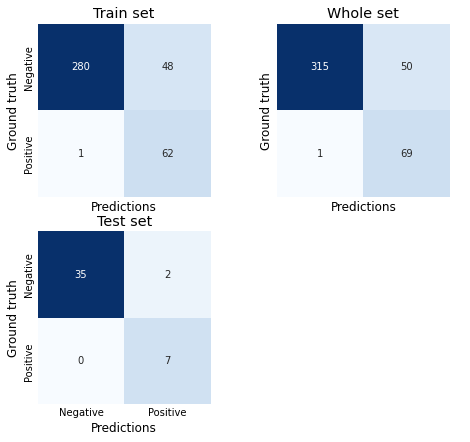

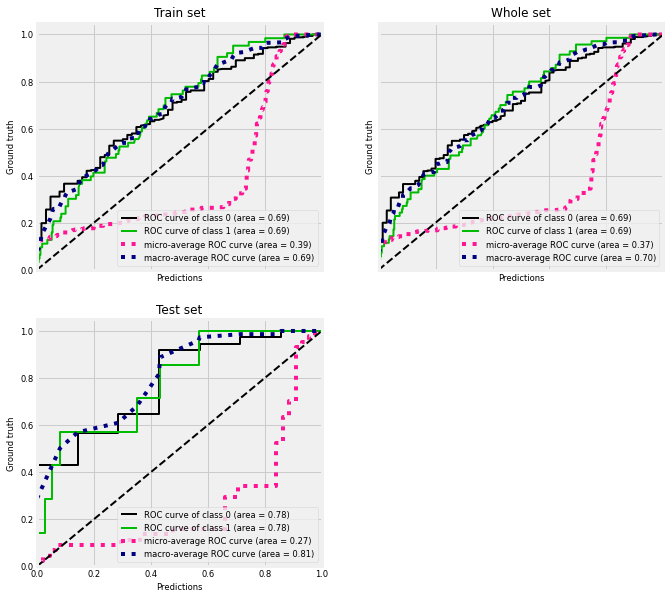

In [51]:
gnb_ensemble = create_ensemble_optimized(GaussianNB, {})
visualise_ensemble(gnb_ensemble, 1.35)  


Как видно - смысла не густо...

## Идеи под конец

`GNB` очень удивил, пока не все потеряно  
`XGBRegressor` показал кто дома отец

## Дополнительные штучки

Я наверное буду писать про самый точный и важный регрессов исключительно, проверить на остальных не составит труда

### Feature importances

In [52]:
def plot_feature_importances(name, ensemble):
    res = []
    for clf in ensemble:
        res.append(clf.feature_importances_)

    res = np.array(res)

    fig, ax = plt.subplots(figsize = (15,10))
    fi = pd.DataFrame(data=np.mean(res, axis=0),
                      index=ensemble[0].feature_names_in_,
                    columns=['importance'])
    fi.sort_values('importance').plot(kind='barh', title=f'Mean feature Importance for {name} ensemble', ax = ax)
    plt.show()


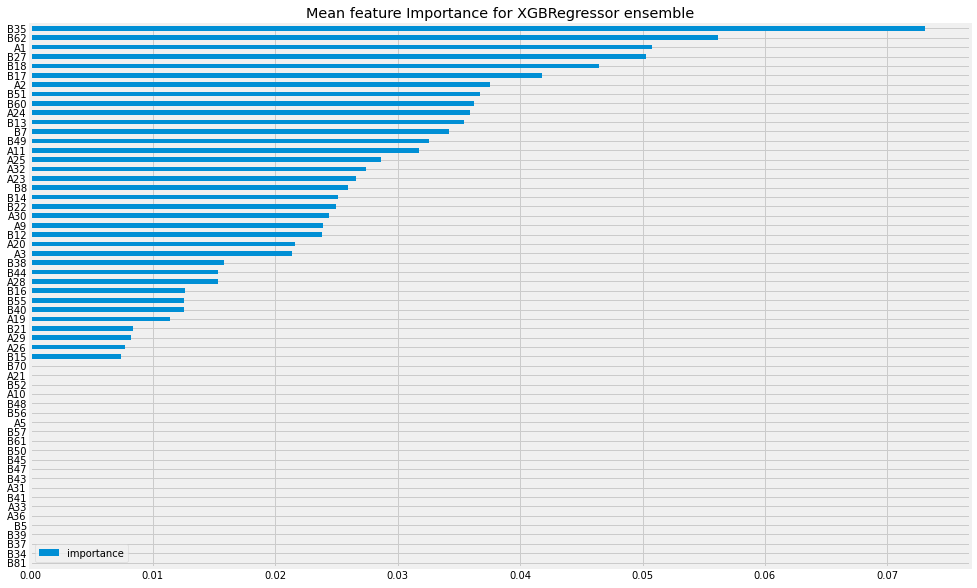

In [53]:
plot_feature_importances('XGBRegressor', xgb_ensemble)